#Install  packages

In [ ]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




##Load The Packages

In [ ]:
library(tidyverse)
library(scales)
library(caret)
library(data.table)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




##Load the Data

In [ ]:
train = read.csv("/content//Train.csv",na.strings = c(" ","NA"))
glimpse(train)
test = read.csv("/content//Test.csv",na.strings = c(" ","NA"))
glimpse(test)

Rows: 8,585
Columns: 679
$ child_id                         <chr> "ID_SYSJ2FM0D", "ID_J5BTFOZR3", "ID_R…
$ data_year                        <dbl> 2022, 2019, 2022, 2021, 2021, 2019, 2…
$ child_date                       <chr> "2022-02-03", "", "2022-03-11", "2021…
$ child_age                        <dbl> 59.00000, 60.16393, 69.00000, 53.0000…
$ child_enrolment_date             <chr> "", "", "", "2020-01-15", "2021-10-13…
$ child_months_enrolment           <dbl> NA, NA, NA, 20, 0, NA, NA, 44, NA, NA…
$ child_grant                      <chr> "", "", "", "No", "", "", "No", "Yes"…
$ child_years_in_programme         <chr> "", "1st year in the programme", "", …
$ child_height                     <dbl> NA, 103.0, 108.4, 98.1, 114.0, 108.4,…
$ child_observe_attentive          <chr> "Sometimes", "Sometimes", "Often", "A…
$ child_observe_concentrated       <chr> "Sometimes", "Almost never", "Often",…
$ child_observe_diligent           <chr> "Sometimes", "Sometimes", "Sometimes"…
$ child_observe

####Combine the datasets

In [ ]:

df = rbind(within(train,rm('child_id','target')),within(test,rm('child_id')))
glimpse(df)

###Missing Values

In [ ]:
na.cols = which(colSums(is.na(df))>0)
sort(colSums(sapply(df[na.cols],is.na)),decreasing = T) %>% View()
paste('There are', length(na.cols), 'columns with missing values')
na.cols = as.data.frame(na.cols)
na.cols$name = rownames(na.cols)
na.cols$name
df_1 = df[,names(df) %in% na.cols$name]
miss = sapply(df,function(x) percent(sum(is.na(x))/nrow(df)))
miss_percent = data.frame(variables = names(miss),percent_missing=miss) %>% 
  as.tibble() %>% 
  filter(percent_missing>"70%") %>% 
  arrange(desc(percent_missing))

In [ ]:
#Variables to be imputed
var_impute=df[,!names(df) %in% miss_percent$variables]
#Variables to be dropped
var_drop = df[,names(df) %in% miss_percent$variables]

##Drop variables with >70% missingness
df[,names(var_drop)]  =NULL
glimpse(df)
sum(is.na(df))
colSums(is.na(df))

###Impute the missing values

In [ ]:
my_mode <- function (x, na.rm) {
  xtab <- table(x)
  xmode <- names(which(xtab == max(xtab)))
  if (length(xmode) > 1) xmode <- ">1 mode"
  return(xmode)
}

for (var in 1:ncol(df)) {
  if (class(df[,var])=="numeric") {
    df[is.na(df[,var]),var] <- mean(df[,var], na.rm = TRUE)
  } else if (class(df[,var]) %in% c("character", "factor")) {
    df[is.na(df[,var]),var] <- my_mode(df[,var], na.rm = TRUE)
  }
}

###Deal with NAs for good

```
# This is formatted as code
```

y

In [ ]:
na.cols_1 = which(colSums(is.na(df))>0)
sort(colSums(sapply(df[na.cols_1],is.na)),decreasing = T) 
paste('There are', length(na.cols_1), 'columns with missing values')
select(df,contains(c("pri_ti"))) %>% View()
for(i in which(sapply(df,is.numeric))){
  df[is.na(df[, i]),i] <- median(df[, i], na.rm = T)
}

####Convert variables into their correct format

In [ ]:

df = df %>% 
  mutate_at(vars(matches(c("date","dob"))),function(x)return(as.Date(x)))


###Dividing the df into NUM & CATEGORICAL

In [ ]:

num_features = names(which(sapply(df,is.numeric)))
cat_features = names(which(sapply(df,is.character)))
date_col = select(df,contains(c("date","dob"))) %>% glimpse()

###Correlation

In [ ]:
install.packages("corrplot")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



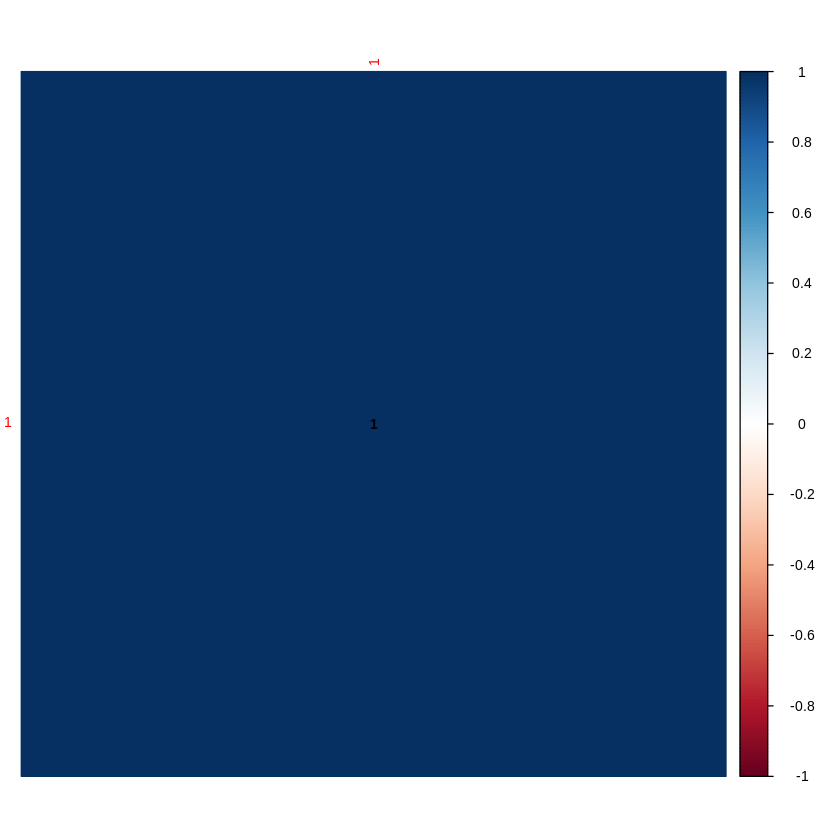

In [ ]:

df.numeric = df[num_features]
corr.df = cbind(df.numeric[1:8585,],train['target'])
correlation = cor(corr.df)
#cols that show strong correlation with target
corr.target = as.matrix(sort(correlation[,'target'],decreasing = T))
corr.idx = names(which(apply(corr.target,1,function(x) (x>0.5 | x < -.5))))
corrplot::corrplot(as.matrix(correlation[corr.idx,corr.idx]),
                   type = 'upper',method = 'color',addCoef.col = 'black',
                   tl.cex = .7,cl.cex = .7,number.cex = .7)

######Median ELOM Score per province

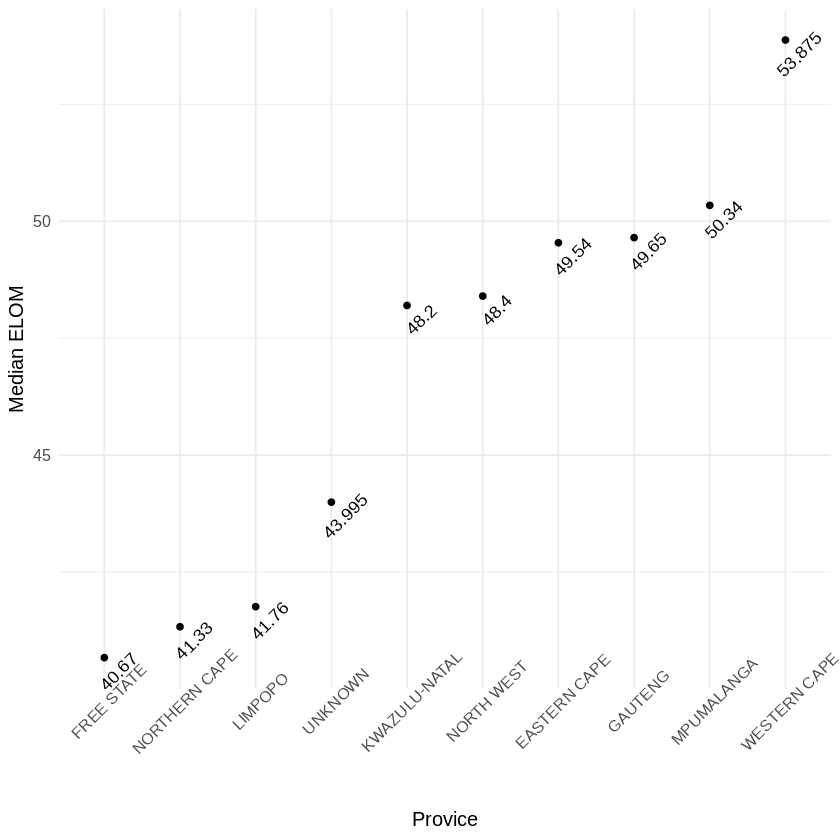

In [ ]:
train[,c('prov_best','target')] %>%
  group_by(prov_best) %>%
  summarise(median.ELOM = round(median(target, na.rm = TRUE),3)) %>% 
  arrange(median.ELOM) %>%
  mutate(provice.sorted = factor(prov_best, levels=prov_best))   %>%
  ggplot(aes(x=provice.sorted, y=median.ELOM)) +
  geom_point() +
  geom_text(aes(label = median.ELOM, angle = 45), vjust = 2) +
  theme_minimal() +
  labs(x='Provice', y='Median ELOM') +
  theme(text = element_text(size=12),
        axis.text.x = element_text(angle=45))

###PCA

In [ ]:
require(factoextra)
pmatrix = df.numeric %>%
  prcomp( center = TRUE, scale. = TRUE)

pcaVar <- as.data.frame(c(get_pca_var(pmatrix)))

# lets
pcaVarNew <- pcaVar[, 1:10]

##Pre-Processing

In [ ]:
install.packages("psych")
install.packages("moments")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘mnormt’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:

require(psych)
library(moments)
# linear models assume normality from dependant variables 
# transform any skewed data into normal
skewed <- apply(df.numeric, 2, skewness)
skewed <- skewed[(skewed > 0.8) | (skewed < -0.8)]

kurtosis <- apply(df.numeric, 2, kurtosi)
kurtosis <- kurtosis[(kurtosis > 3.0) | (kurtosis < -3.0)]
# normalize the data
library(caret)
scaler <- preProcess(df.numeric)
df.numeric <- predict(scaler, df.numeric)

Loading required package: psych


Attaching package: ‘psych’


The following objects are masked from ‘package:scales’:

    alpha, rescale


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha




In [ ]:
install.packages("fastDummies")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
df.categoric = df[cat_features]

In [ ]:
#For the rest of the categoric features we can 
#one-hot encode each value to get as many splits in 
#the data as possible

# one hot encoding for categorical data
# sparse data performs better for trees/xgboost
library(fastDummies)
dummy <- dummyVars(" ~ .",data=df[,cat_features])
df.categoric = df.categoric %>% select(-contains(c("date","dob")))
df.categoric <- data.frame(predict(dummy,newdata=df[,cat_features]))


In [ ]:
#####
## Extract date features from the date columns
for (col in date_col){
  df[paste(col, 'Year', sep=" ")] = format(df[col], "%Y")
  df[paste(col, 'Month', sep=" ")] = format(df[col], "%m")
  df[paste(col, 'Day', sep=" ")] = format(df[col], "%d")
}

ERROR: ignored

In [ ]:
###|Combine
df <- cbind(df.numeric, df.categoric,date_col)

In [ ]:
#####################NearZero
nzv.data <- nearZeroVar(df, saveMetrics = TRUE)

# take any of the near-zero-variance perdictors
drop.cols <- rownames(nzv.data)[nzv.data$nzv == TRUE]

df <- df[,!names(df) %in% drop.cols]

paste('The dataframe now has', dim(df)[1], 'rows and', dim(df)[2], 'columns')


[1] "The dataframe now has 12265 rows and 1271 columns"

#Modelling
###XGBoost

In [ ]:
install.packages("xgboost")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:

library(xgboost)
#Splitting data(HandOut Method)
y_train <- log(train$target+1)
x_train <- df[1:8585,]

x_test <- df[8585:nrow(df),]





Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




##Simple Modelling

In [ ]:

#We want to be in control of validation
my_control <- trainControl(method = "cv",
                           number = 8,
                           verboseIter = F)
#Fit the model 
xgb_model <- suppressWarnings(suppressMessages(train(data.matrix(x_train),
                                                     y_train,
                                                     method = 'xgbTree',
                                                     trControl = cv_ctr)))

In [ ]:
install.packages("doSNOW")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘snow’




In [ ]:
#For multi-core training because we are training alot of trees
library(doSNOW) 
cl=makeCluster(6,type = "SOCK")
registerDoSNOW(cl)
# Set seed for reproducability
set.seed(1234)
dtrain <- xgb.DMatrix(data.matrix(x_train), label = y_train)
dtest <- xgb.DMatrix(data.matrix(x_test))

cv.ctrl <- trainControl(method = "repeatedcv", repeats = 1,number = 4, 
                        allowParallel=T)

xgb.grid <- expand.grid(nrounds = 750,
                        eta = c(0.01,0.005,0.001),
                        max_depth = c(4,6,8),
                        colsample_bytree=c(0,1,10),
                        min_child_weight = 2,
                        subsample=c(0,0.2,0.4,0.6),
                        gamma=0.01)

In [ ]:
#Train the model
xgb_tune <- train(data.matrix(x_train),
        y_train,
        method="xgbTree",
        trControl=cv.ctrl,
        tuneGrid=xgb.grid,
       verbose=T,
      metric="RMSE", nthread =3)

stopCluster(cl)

###Tune the parameters

In [ ]:
xgb_params <- list(
  booster = 'gbtree',
  objective = 'reg:linear',
  colsample_bytree=1,
  eta=0.005,
  max_depth=4,
  min_child_weight=3,
  alpha=0.3,
  lambda=0.4,
  gamma=0.01, # less overfit
  subsample=0.6,
  seed=5,
  silent=TRUE)

In [ ]:
#How well my model generalizes to testing data
xgb.cv(xgb_params, dtrain, nrounds = 5000, nfold = 4,
early_stopping_rounds = 500)

In [ ]:
#Train the model

bst <- xgb.train(xgb_params,dtrain, nrounds = 1000)#,early_stopping_rounds = 300, watchlist = list(train=dtrain))))

Warning message in xgb.train(xgb_params, dtrain, nrounds = 1000):
“xgb.train: `seed` is ignored in R package.  Use `set.seed()` instead.”


[07:17:34] WARNING: src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[07:17:34] WARNING: src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [ ]:
###Fearture importance
model.names <- dimnames(dtrain)[[2]]

importance_matrix <- xgb.importance(model.names, model = bst)

xgb.plot.importance(importance_matrix[1:15])

In [ ]:
importance_matrix[1:15,1]

Feature
<chr>
child_age
child_observe_diligentAlmost.never
child_observe_attentiveAlmost.always
teacher_emotional_total
child_height
id_enumerator
child_observe_diligentSometimes
child_date
id_team


In [ ]:
rmse_eval <- function(y_train, y.pred) {
  mse_eval <- sum((y_train - exp(y.pred)-1)^2) / length(y_train)
  return(sqrt(mse_eval))
}

y_pred.xgb <- predict(bst, dtrain)
rmse_eval(y_train, y_pred.xgb)

[1] 45.16915

In [ ]:
y_pred.xgb <- as.double(predict(bst, dtest))
y_pred.xgb <- as.double(exp(y_pred.xgb) - 1)

In [ ]:
model.names <- dimnames(dtrain)[[2]]

importance_matrix <- xgb.importance(model.names, model = bst)

xgb.plot.importance(importance_matrix[1:15])

In [ ]:
head(y_pred.xgb)

[1] 42.15571 54.53755 47.32464 44.02907 60.06183 39.42832

In [ ]:
head(test$child_id)

[1] "ID_0I0999N6S" "ID_GQ6ONJ4FP" "ID_YZ76CVRW3" "ID_BNINCRXH8" "ID_1U7GDTLRI"
[6] "ID_HUPM6GALH"

In [ ]:
nrow(y_pred.xgb)

NULL

In [ ]:
sample = read.csv("/content/SampleSubmission.csv")

In [ ]:
# Create a submission file
sub_file = setNames(sample,  names(sample))
sub_file$target = y_pred.xgb

In [ ]:
dim(importance_matrix)

[1] 616   4

In [ ]:
(y_pred.xgb)

ERROR: ignored

In [ ]:
submission = data.frame(child_id = test$child_id[1:616],target = y_pred.xgb[1:616],feature_1 = importance_matrix$Feature
,feature_2 = importance_matrix$Feature,feature_3 = importance_matrix$Feature,feature_4 = importance_matrix$Feature
,feature_5 = importance_matrix$Feature,feature_6 = importance_matrix$Feature,feature_7 = importance_matrix$Feature
,feature_8 = importance_matrix$Feature,feature_9 = importance_matrix$Feature,feature_10 = importance_matrix$Feature
,feature_11 = importance_matrix$Feature,feature_12 = importance_matrix$Feature,feature_13 = importance_matrix$Feature
,feature_14 = importance_matrix$Feature,feature_15 = importance_matrix$Feature)


In [ ]:
submission1 = data.frame(child_id = test$child_id[1:3680],target = y_pred.xgb[1:3680],
)

ERROR: ignored

In [ ]:
sub_file1 = setNames(sample,colnames(sample))
sub_file1$target = y_pred.xgb %>% head()

In [ ]:
head(sub_file1)

,child_id,target,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ID_0I0999N6S,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
2,ID_GQ6ONJ4FP,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
3,ID_YZ76CVRW3,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
4,ID_BNINCRXH8,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
5,ID_1U7GDTLRI,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature
6,ID_HUPM6GALH,0,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature,feature


In [ ]:
head(submission)

In [ ]:
# Create a csv file and upload to zindi 
write.csv(submission, 'Baseline.csv', row.names=FALSE)

In [ ]:
child_id = test$child_id
Df <- data.frame(id=child_id,attr(importance_matrix$Feature[1:15], "row.names"), check.rows= FALSE)

ERROR: ignored

In [ ]:
importance_matrix$Feature[1:15]

[1] "child_age"                             
 [2] "child_observe_diligentAlmost.never"    
 [3] "child_observe_attentiveAlmost.always"  
 [4] "teacher_emotional_total"               
 [5] "child_height"                          
 [6] "id_enumerator"                         
 [7] "child_observe_diligentSometimes"       
 [8] "child_date"                            
 [9] "id_team"                               
[10] "child_observe_attentiveOften"          
[11] "child_observe_interestedAlmost.always" 
[12] "child_observe_diligentAlmost.always"   
[13] "pri_fees_amount"                       
[14] "latitude"                              
[15] "child_observe_concentratedAlmost.never"

In [ ]:
# Create a submission file
y_pred.xgb = mutate(child_id = test$child_id)
sub_file = setNames(sample,  importance_matrix[1:15,1])
sub_file$target = predictions

# ridge, lasso, elasticnet

In [ ]:
install.packages("glmnet")

In [ ]:
install.packages("Matrix")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(glmnet)
library(Matrix)
glm.cv.ridge <- cv.glmnet(as.matrix(x_train), y_train, alpha = 0)
glm.cv.lasso <- cv.glmnet(as.matrix(x_train), y_train, alpha = 1)
glm.cv.net <- cv.glmnet(data.matrix(x_train), y_train, alpha = 0.001)

# use the lamdba that minimizes the error
penalty.ridge <- glm.cv.ridge$lambda.min
penalty.lasso <- glm.cv.lasso$lambda.min
penalty.net <- glm.cv.net$lambda.min

ERROR: ignored

####Lets train our model using our chosen λ

In [ ]:
glm.ridge <- glmnet(x = as.matrix(x_train), y = y_train, alpha = 0, lambda = penalty.ridge )
glm.lasso <- glmnet(x = as.matrix(x_train), y = y_train, alpha = 1, lambda = penalty.lasso)
glm.net <- glmnet(x = as.matrix(x_train), y = y_train, alpha = 0.001, lambda = penalty.net)

y_pred.ridge <- as.numeric(predict(glm.ridge, as.matrix(x_train)))
y_pred.lasso <- as.numeric(predict(glm.lasso, as.matrix(x_train)))
y_pred.net <- as.numeric(predict(glm.net, as.matrix(x_train)))
rmse_eval(y.true, y_pred.ridge)
rmse_eval(y.true, y_pred.lasso)
rmse_eval(y.true, y_pred.net)

##Make Predictions

In [ ]:
#y_pred.ridge <- as.double(predict(glm.ridge, as.matrix(x_test)))
#y_pred.lasso <- as.double(predict(glm.lasso, as.matrix(x_test)))
#y_pred.net <- as.double(predict(glm.net, as.matrix(x_test)))

#y_pred.ridge <- as.double(exp(y_pred.ridge) - 1)
#y_pred.lasso <- as.double(exp(y_pred.lasso) - 1)
#y_pred.net <- as.double(exp(y_pred.net) - 1)

#y_pred.xgb <- as.double(predict(bst, dtest))
#y_pred.xgb <- as.double(exp(y_pred.xgb) - 1)

# take the average of our predictions for our ensemble
#y_pred <- (y_pred.xgb + y_pred.ridge + y_pred.lasso + y_pred.net)/4.0
#head(y_pred)